# Vowel Detection Neural Network

## Introduction
1. Train a Feedforward Neural Networks to recognize a vowel based on Linear Predictive Coding (LPC) Coefficients (`LPC14`)
2. Dataset Pairs `<LPC14 Coefficients of vowels, 1 Hot Encoding of Vowels>`
3. Change the number of hidden Layer Neural Network neurons to see which architecture best minimizes loss

### Vowel Classification
| Backness         | Vowel Transcription | [IPA](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://en.wikipedia.org/wiki/International_Phonetic_Alphabet&ved=2ahUKEwitgoiUvPWEAxUhGDQIHR2IDMoQFnoECBQQAQ&usg=AOvVaw3T7iQw-yz0dlfkE0oDRulL) | One Hot Encoding Index |
| ---------------- | ------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------------------- |
| Front            | iy                  | `i`                                                                                                                                                                                                                     | 1                      |
| Front            | ih                  | `ɪ`                                                                                                                                                                                                                     | 2                      |
| Front            | ey                  | `ɛ`                                                                                                                                                                                                                     | 3                      |
| Front            | eh                  | `æ`                                                                                                                                                                                                                     | 4                      |
| Front (diphtong) | ae                  | `ei`                                                                                                                                                                                                                    | 5                      |
| Back             | uw                  | `u`                                                                                                                                                                                                                     | 6                      |
| Central          | uh                  | `ə`                                                                                                                                                                                                                     | 7                      |
| Back             | ow                  | `o`                                                                                                                                                                                                                     | 8                      |
| Back             | ao                  | `ɔ`                                                                                                                                                                                                                     | 9                      |
| Back             | aa                  | `ɑ`                                                                                                                                                                                                                     | 10                     |

## Step 0) Import Libraries and Dataset Constants

In [353]:
# PyTorch for feedforward NN architecture library
import torch
import torch.optim as optim

# Science Python library for loading matlab `.mat` files containing training data `ground_truth.mat` and `training_lpc.mat` 
import scipy.io

# Plotting libraries for analyzing the loss and accuracy of the model
import matplotlib.pyplot as plt
import numpy as np

# For pathing
import os
import glob

## Step 1) Import Training Data

In [354]:
# Declare LPC or MFCC Mode
PARAMETERIZATION_TYPE = "LPC"
if PARAMETERIZATION_TYPE != "LPC" and PARAMETERIZATION_TYPE != "MFCC":
    raise(ValueError(f"PARAMETERIZATION_TYPE is {PARAMETERIZATION_TYPE}, but must be 'LPC' or 'MFCC."))

NUM_COEFFICIENTS = 14
VOWEL_LIST = ["iy", "ih", "eh", "ae", "ey", "uw", "uh", "ow", "ao", "aa"]

In [355]:
# Load in inputs and ouput data from Matlab .mat files
def load_dataset(mat_file_path: str, num_coefficient: int, num_labels:int, input_key: str, label_key: str) -> tuple[np.ndarray, np.ndarray]:
    # Step 1) Load in the `.mat` extension as a list
    data_as_arr = scipy.io.loadmat(mat_file_path)
    inputs_as_arr = data_as_arr[input_key]
    outputs_as_arr = data_as_arr[label_key]

    # Step 2) Reshape as an n by m 2D array where n=num_samples and m=num_coefficient
    input_as_nd_arr = torch.tensor(np.array(inputs_as_arr).reshape(-1, num_coefficient), dtype=torch.float)
    output_as_nd_arr = torch.tensor(np.array(outputs_as_arr).reshape(-1, num_labels), dtype=torch.float)

    print("TODO DEBUG REMOVE: ", input_as_nd_arr.shape, outputs_as_arr.shape)
    return input_as_nd_arr, output_as_nd_arr

In [356]:
COEFFICIENT_DATASET_KEY = "wav_parameterization"
ENCODING_DATASET_KEY = "one_hot_encoding_labels"

In [357]:
# Import Training Dataset
TRAINING_DATASET_FOLDER = "../Matlab/data/InClass"
TRAINING_DATASET_INPUTS = os.path.join(
    TRAINING_DATASET_FOLDER, f"{PARAMETERIZATION_TYPE}*.mat"
)

training_path = glob.glob(TRAINING_DATASET_INPUTS)[0]

training_dataset = load_dataset(
    mat_file_path=training_path,
    num_coefficient=NUM_COEFFICIENTS,
    num_labels=len(VOWEL_LIST),
    input_key=COEFFICIENT_DATASET_KEY,
    label_key=ENCODING_DATASET_KEY
)

TODO DEBUG REMOVE:  torch.Size([236, 14]) (236, 10)


In [358]:
TEST_DATASET_PATH = "../Matlab/data/Hillenbrand/"
test_types = ["man", "woman", "boy", "girl"]

testing_data: dict[str, tuple[np.ndarray, np.ndarray]] = {
    speaker_type: load_dataset(
        mat_file_path=glob.glob(
            os.path.join(TEST_DATASET_PATH,
                         speaker_type,
                         f"{PARAMETERIZATION_TYPE}*.mat"
                         ))[0],
        num_coefficient=NUM_COEFFICIENTS,
        num_labels=len(VOWEL_LIST),
        input_key=COEFFICIENT_DATASET_KEY,
        label_key=ENCODING_DATASET_KEY
    )
    for speaker_type in test_types
}

TODO DEBUG REMOVE:  torch.Size([90, 14]) (90, 10)
TODO DEBUG REMOVE:  torch.Size([100, 14]) (100, 10)
TODO DEBUG REMOVE:  torch.Size([90, 14]) (90, 10)
TODO DEBUG REMOVE:  torch.Size([90, 14]) (90, 10)


In [359]:
SAVE_DATA_PATH = "./training_losses/"

## Step 2) Generate Model Architecture
- As we are trying to use different model architecture, we will use a function to encapsulate the model parameters

In [360]:
# Model Hyperparameters
LEARNING_RATE = 0.1
NUM_EPOCHS = 100000

# Model Architecture
INPUT_SIZE = NUM_COEFFICIENTS
OUTPUT_SIZE = len(VOWEL_LIST)

### Step 2a) Create Vowel Classifier Architecutre
- Use a function to create the Feedforward NN architecture and its respective Stochastic Gradient Descent optimizer


Note: Model Has the following architecture:

| Layer # | Description                                          | Size                                                                   |
| ------- | ---------------------------------------------------- | ---------------------------------------------------------------------- |
| 1       | Input Neurons containing the LPC Values              | 14 (1 per LPC coefficient)                                             |
| 2       | Hidden Layer to convexify the classification problem | 1-5 (independent variable to see which architecture performs the best) |
| 3       | One Hot Encoding of the vowel                        | 10 (ten vowels)                                                        |

```
  Layer 1            Layer 2         Layer 3
    I1                                 
    I2                                 O1
    I3                                 O2
    I4                                 O3
    ...                X               ...
    I11                                O10
    I13
    I14  
```                               

In [361]:
def create_lpc_vowel_classifier(
    NUM_LPC: int,
    HIDDEN_LAYER_SIZE: int,
    ONE_HOT_ENCODING_SIZE: int,
    LEARNING_RATE: float
) -> tuple[torch.nn.Module, torch.optim.Optimizer]:
    """
    Creates a Feedforward Neural Network and an optimizer to improve the loss of the model.

    ## Parameters
    INPUT_SIZE: int
        Number of inputs to the NN (in our case, the number of LPCs)

    HIDDEN_LAYER_SIZE: int
        Number of inputs from Input to the Hidden Layer (variable for experimentation purposes)

    ONE_HOT_ENCODING_SIZE: int
        The final output layer's dimensions for the One Hot Encoding of the vowel

    LEARNING_RATE: float
        Learning Rate for the Stochastic Gradient Descent Optimizer    

    ## Returns
    model: torch.nn.Module
        feedforward NN with randomized weights and biases whose architecture is based on the function parameters
    optimzer: torch.optim.Optimizer
        Stochastic Gradient Descent object that uses the gradients calculated 
        by a `loss_function` to update the `model`'s weights and biases
    """

    # Step 1) Create the model architecture
    model = torch.nn.Sequential(
        # Layer 1
        torch.nn.Linear(NUM_LPC, HIDDEN_LAYER_SIZE),
        torch.nn.Sigmoid(),

        # Layer 2
        torch.nn.Linear(HIDDEN_LAYER_SIZE, ONE_HOT_ENCODING_SIZE),
    )
    
    # Step 2) Create the Stochastic Gradient Descent object
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

    return model, optimizer

## Step 2B) Train Classifier
- Next we will have a function responsible for the training iterations of the `optimizer` and `model` we create from `create_lpc_vowel_classifier`

### Loss Function Type
- The `loss_function` sums the Mean Squared Error of `model prediction` vs `ground truth` 
- The loss is summed over all 218 samples of vowels using the `reduction=sum` flag

## Step 3) Analyze Data Visually
1. Use a plot for seeing the loss of the values over time
2. Visualize the prediction of the model using a 2D color plot
3. Overlay the loss values of different trials of training

In [362]:
def plot_all(
    loss_history: np.ndarray,
    num_trials: int,
    unit: int
) -> None:
    """
    Plots the loss of the first `num_trials` training sessions (A-E) of the Vowel Classifier for NN with 1 - 5 hidden neurons.

    Note: In this context, training session means an entire re-initialization of weights and biases of a fresh Neural Network
    
    ## Parameters
    loss_history: np.ndarray
        Shape: (Number of neurons in the hidden layer, number of training sessions, NUM_EPOCHS//CLOCK_RATE)
        A 3D numpy array where the x index is the number of hidden neurons and the y is the training session number, 
        and z is the recorded loss at every `CLOCK_RATE`th iteration.
    
    num_trials: int
        Plots the entire loss history for the first `num_trials` for each of the neural network architectures
    
    unit: int
        The number of training iterations that elapse between each Z index of loss_history(_, _, Z) 
        if unit = 1,000 iterations
        ex: loss_history(0, 0, 0) represents a neural network with 1 hidden neuron, during training session A, and the loss after the 0th epoch of training
            loss_history(0, 0, 1) represents the same neural network and training session as above and the loss after the `1,000`th epoch of training
    """

    plt.rcParams['figure.figsize'] = (15, 15)
    fig, axes = plt.subplots(nrows=5, ncols=5)
    plt.subplots_adjust(hspace=0.6, wspace=0.6)

    # The first axis in the 3D array is the number of hidden neurons used in the single vowel classification
    num_hidden_neuron_architectures = loss_history[0]

    for neuron_idx in range(num_hidden_neuron_architectures):
        for trial_idx in range(num_trials):
            # Title the graph: ex: Loss of 1 hidden Neurons for Trial A
            title = f"{neuron_idx + 1} Hidden, Trial {chr(ord('A') + trial_idx)}"

            # Format Titles
            cur_subplot = axes[neuron_idx][trial_idx]
            cur_subplot.set_title(title)
            cur_subplot.set_ylabel(f"Loss")
            cur_subplot.set_xlabel(f"1 unit = {unit} iterations")
            cur_subplot.yaxis.grid(True)

            # Format Boxplots for Front vs. Back Vowels
            cur_subplot.plot(loss_history[neuron_idx][trial_idx])

In [363]:
def save_data(
    to_save: list[float], 
    file_path: str, 
    file_name: str
) -> None:
    """
    to_save: list[float]
        The array of training losses to be written to a txt file
    
    file_path: str
        The destination of the file

    file_name: str
        The file name
    """

    # Step 1) Get the directory to create the file in
    directory = os.path.dirname(file_path)

    # Step 1b) if the file directory doesn't exist, make it
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Step 1c) create the full path to write to
    full_path = os.path.join(file_path, file_name)

    # Step 2) Write the entire training loss to that file
    with open(full_path, "w") as file:
        for loss in to_save:
            file.write(f"{loss}\n")

In [364]:
def calculate_cohens_d(dataset1: np.array, dataset2: np.array) -> tuple[np.float32, str]:
    """
    Compare the effect size of dataset1's and dataset2's LPC_X where
    X is an arbitrary LPC Coefficient

    ## Parameters
    lpc_x_dataset1 : np.array
        The Xth LPC coefficients for every sample in dataset 1
            ex: LPC 12 for all `front vowels`
    
    lpc_x_dataset2 : np.array
        The Xth LPC coefficients for every sample in dataset 2
            ex: LPC 12 for all `front vowels`
    
    Note: Both datasets should be have the same LPC index

    ## Returns
    cohens_d : np.float64
        Cohen's D or Effect Size of LPC Index X with respect to dataset 1 and dataset 2
            ex: How likely the difference between LPC X in dataset 1 and dataset 2 
                is to be noticeable in an experiment/real life scenario

    label: str
        Returns whether the effect size is Small, Medium, or Large
    """

    assert len(dataset1) > 1, "dataset1 must have more than 1 number" 
    assert len(dataset1) > 1, "dataset2 must have more than 1 number" 

    # Step 1) Numerator = Mean Difference
    mean_difference = np.mean(dataset1) - np.mean(dataset2)
    
    # Step 2) Get the total variance of both datasets
    total_variance = np.std(dataset1)**2 + np.std(dataset2)**2

    # Step 3) Normalize the Variance
    normalized_variance = np.sqrt(total_variance) / 2

    # Step 4) Calculate effect size
    cohens_d = mean_difference / normalized_variance

    # Step 5) Get the label according to Cohen's D
    label = ""
    if(abs(cohens_d) >= 0.8):
        label = "Large"
    elif(abs(cohens_d) >= 0.5):
        label = "Medium"
    else:
        label = "Small"
        
    return cohens_d, label

## Step 4) Linking It All Together

### Step 4A) Declare the constants of the models

In [365]:
# Number of hidden neurons
# HIDDEN_LAYER_SIZES = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
HIDDEN_LAYER_SIZES = [10]

# Number of trials for testing a single Hidden layer Architecture
NUM_TRIALS = 5

# Record every `Clock_Rate`th sample
CLOCK_RATE = 1000

### Step 4B) Declare the data structures which will hold the loss histories and calculate the loss

In [366]:
# Let there be Five 2D planes where the rows represent the trial number and the columns represent the losses recorded
all_training_loss_histories = np.ndarray(
    (len(HIDDEN_LAYER_SIZES), NUM_TRIALS, NUM_EPOCHS//CLOCK_RATE),
)

all_man_test_loss = np.ndarray(
    (len(HIDDEN_LAYER_SIZES), NUM_TRIALS, NUM_EPOCHS//CLOCK_RATE),
)

all_woman_test_loss = np.ndarray(
    (len(HIDDEN_LAYER_SIZES), NUM_TRIALS, NUM_EPOCHS//CLOCK_RATE),
)

all_boy_test_loss = np.ndarray(
    (len(HIDDEN_LAYER_SIZES), NUM_TRIALS, NUM_EPOCHS//CLOCK_RATE),
)

all_girl_test_loss = np.ndarray(
    (len(HIDDEN_LAYER_SIZES), NUM_TRIALS, NUM_EPOCHS//CLOCK_RATE),
)

# Use normalized Cross Entropy Loss for classification problem (softmax implicitly applied)
loss_function = torch.nn.CrossEntropyLoss()

In [367]:
def train_model(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    training_data: torch.tensor,
    ground_truth: torch.tensor,
    NUM_EPOCHS: int,
    clock_rate: int,
    loss_function: torch.nn.modules.loss._Loss,
    print_loss_flag: bool = True
) -> list[float]:
    """
    Given a `model`, `optimizer`, and `training data`, this function trains the model using the `loss_function` which uses
    `Mean Squared Error` and `sum` by default.

    ## Parameters
    model: torch.nn.Module
        Neural Network Architecture used to train the model

    optimizer: torch.optim.Optimizer
        Training optimization type, default is Stochastic Gradient Descent for this project    
    
    training_data: torch.tensor
        Training data (X, NUM_LPC) matrix where X is the number of training samples.
    
    ground_truth: torch.tensor
        Ground truth data (X, 10) matrix where X is the number of training samples and 10 is the one hot encoding for each vowel
    
    NUM_EPOCHS: int
        Number of epochs to run training iterations for (note that the model may overfit for large numbers of epochs)
    
    clock_rate: int
        The returned list of losses adds the loss at every `clock_rate`th training iteration
    
    loss_function: torch.nn.modules.loss._Loss
        The loss function used to calculate the loss after testing all X training datasets

    print_loss_flag: bool
        Whether or not to print out the error at every `clock_rte`th training iteration to the console
    
    ## Returns
    loss_history: torch.nn.Module
        Records `NUM_EPOCHS//clock_rate` number evenly spaced losses across the training iterations
    """
    # Step 0) Set the model into train mode
    model.train()

    # Step 1) Convert the Training Data and Ground Truthof LPC values into a tensor
    training_tensor = torch.tensor(training_data, dtype=torch.float)
    ground_truth_tensor = torch.tensor(ground_truth, dtype=torch.float)

    loss_history = []

    # Step 2) Train Model
    for i in range(NUM_EPOCHS):

        # Step 2a) Forward Propogate all samples of `training_data`
        vowel_prediction = model(training_tensor)

        # Step 2b) Calculate the loss
        loss = loss_function(vowel_prediction, ground_truth_tensor)

        # Step 2c) Calculate the new gradient (note: we need zero_grad() to clear the previous training iterations gradient)
        optimizer.zero_grad()
        loss.backward()

        # Step 2d) Apply the gradient with the learning rate to updated the weighs and biases
        optimizer.step()

        # Step 3) Record loss history

        if print_loss_flag and i % clock_rate == 0:
            loss_history.append(loss.item())
            print(loss.item())

    return loss_history

In [368]:
# Unpack Training and Testing Data
training_inputs, training_ground_truth = training_dataset

In [369]:
print_loss_flag = True

### Step 4C) Train each model architecture over `NUM_TRIALS` trials

In [370]:
for num_hidden_neurons in HIDDEN_LAYER_SIZES:
    # Change the number of hidden neurons in the hidden layer
    
    for trial_num in range(NUM_TRIALS):
        # Step 1) Create Model
        model, optimizer = create_lpc_vowel_classifier(
            NUM_LPC=INPUT_SIZE,
            HIDDEN_LAYER_SIZE=num_hidden_neurons,
            ONE_HOT_ENCODING_SIZE=OUTPUT_SIZE,
            LEARNING_RATE=LEARNING_RATE
        )

        # Step 2) Train the model
        # loss_history = train_model(
        #     model=model,
        #     optimizer=optimizer,
        #     training_data=training_inputs,
        #     ground_truth=training_ground_truth,
        #     NUM_EPOCHS=NUM_EPOCHS,
        #     loss_function=loss_function,
        #     clock_rate=CLOCK_RATE
        # )

        model.train()
        loss_history = []

        # Step 2) Train Model
        for i in range(NUM_EPOCHS):

            # Step 2a) Forward Propogate all samples of `training_data`
            vowel_prediction = model(training_inputs)

            # Step 2b) Calculate the loss
            loss = loss_function(vowel_prediction, training_ground_truth)

            # Step 2c) Calculate the new gradient (note: we need zero_grad() to clear the previous training iterations gradient)
            optimizer.zero_grad()
            loss.backward()

            # Step 2d) Apply the gradient with the learning rate to updated the weighs and biases
            optimizer.step()

            # Step 3) Record loss history
            if print_loss_flag and i % CLOCK_RATE == 0:
                loss_history.append(loss.item())
                print(loss.item())
    
                # Step 4) Record Testing Loss
                model.eval()

                for demographic in test_types:
                    test_inputs, test_labels = testing_data[demographic]
                    test_prediction = model(test_inputs)
                    
                    test_loss = loss_function(test_prediction, test_labels)
                    print(demographic, test_loss.item())
                    test_accuracy = (torch.argmax(test_prediction, 1) == torch.argmax(test_labels, 1)).float().mean()
                    print(demographic, test_accuracy)
                
        # Step 3) Record Training Loss 
        # save_data(loss_history, SAVE_DATA_PATH, f"{num_hidden_neurons}_Hidden_Neurons_Trial_{chr(ord('A') + trial_num)}") 
        all_training_loss_histories[num_hidden_neurons - 1][trial_num] = loss_history
        loss_history.clear()



2.4025022983551025
man 2.39536714553833
man tensor(0.1000)
woman 2.3977210521698
woman tensor(0.1000)
boy 2.3875205516815186
boy tensor(0.1000)
girl 2.386627674102783
girl tensor(0.1000)
1.8512892723083496
man 2.5377633571624756
man tensor(0.0444)
woman 2.57890248298645
woman tensor(0.0100)
boy 2.570186138153076
boy tensor(0.0333)
girl 2.567405939102173
girl tensor(0.0111)
1.6582494974136353
man 2.853508472442627
man tensor(0.0889)
woman 2.791684150695801
woman tensor(0.1000)
boy 2.780745029449463
boy tensor(0.1000)
girl 2.7683627605438232
girl tensor(0.1000)


1.541477918624878
man 3.114786386489868
man tensor(0.1000)
woman 3.08974552154541
woman tensor(0.1000)
boy 3.083080291748047
boy tensor(0.1000)
girl 3.0782861709594727
girl tensor(0.1000)
1.4510316848754883
man 3.50604510307312
man tensor(0.1000)
woman 3.6213881969451904
woman tensor(0.1000)
boy 3.6248281002044678
boy tensor(0.1000)
girl 3.627150535583496
girl tensor(0.1000)
1.3731111288070679
man 4.020352363586426
man tensor(0.1000)
woman 4.283670425415039
woman tensor(0.1000)
boy 4.303718090057373
boy tensor(0.1000)
girl 4.304202556610107
girl tensor(0.1000)
1.3107620477676392
man 4.509690284729004
man tensor(0.1000)
woman 4.889331340789795
woman tensor(0.1000)
boy 4.925160884857178
boy tensor(0.1000)
girl 4.923819541931152
girl tensor(0.1000)
1.2548432350158691
man 4.94602632522583
man tensor(0.1000)
woman 5.407067775726318
woman tensor(0.1000)
boy 5.453681945800781
boy tensor(0.1000)
girl 5.4465012550354
girl tensor(0.1000)
1.2053028345108032
man 5.3557915687561035
man tensor(0.100

IndexError: index 9 is out of bounds for axis 0 with size 1

## Step 5) Visualizing the Data
A) Plot Losses
B) Last Loss per architecture
C) Visualize Classification

### Step 5A) Plot Losses
- Plot the losses for 5 trials of each neural network architecture

In [ ]:
plot_all(loss_history=all_training_loss_histories, num_hidden_neurons=len(HIDDEN_LAYER_SIZES), num_trials=5, unit=NUM_EPOCHS//CLOCK_RATE)

TypeError: plot_all() got an unexpected keyword argument 'num_hidden_neurons'

### Step 5B) Last Loss per architecture
- Find how the median loss varies vs the number of neurons in the hidden layer

Median Losses: 162.95408630371094
Median Losses: 134.2169952392578
Median Losses: 109.7592544555664
Median Losses: 90.50627517700195
Median Losses: 76.25634384155273


Text(0.5, 0, 'Number of Hidden Neurons')

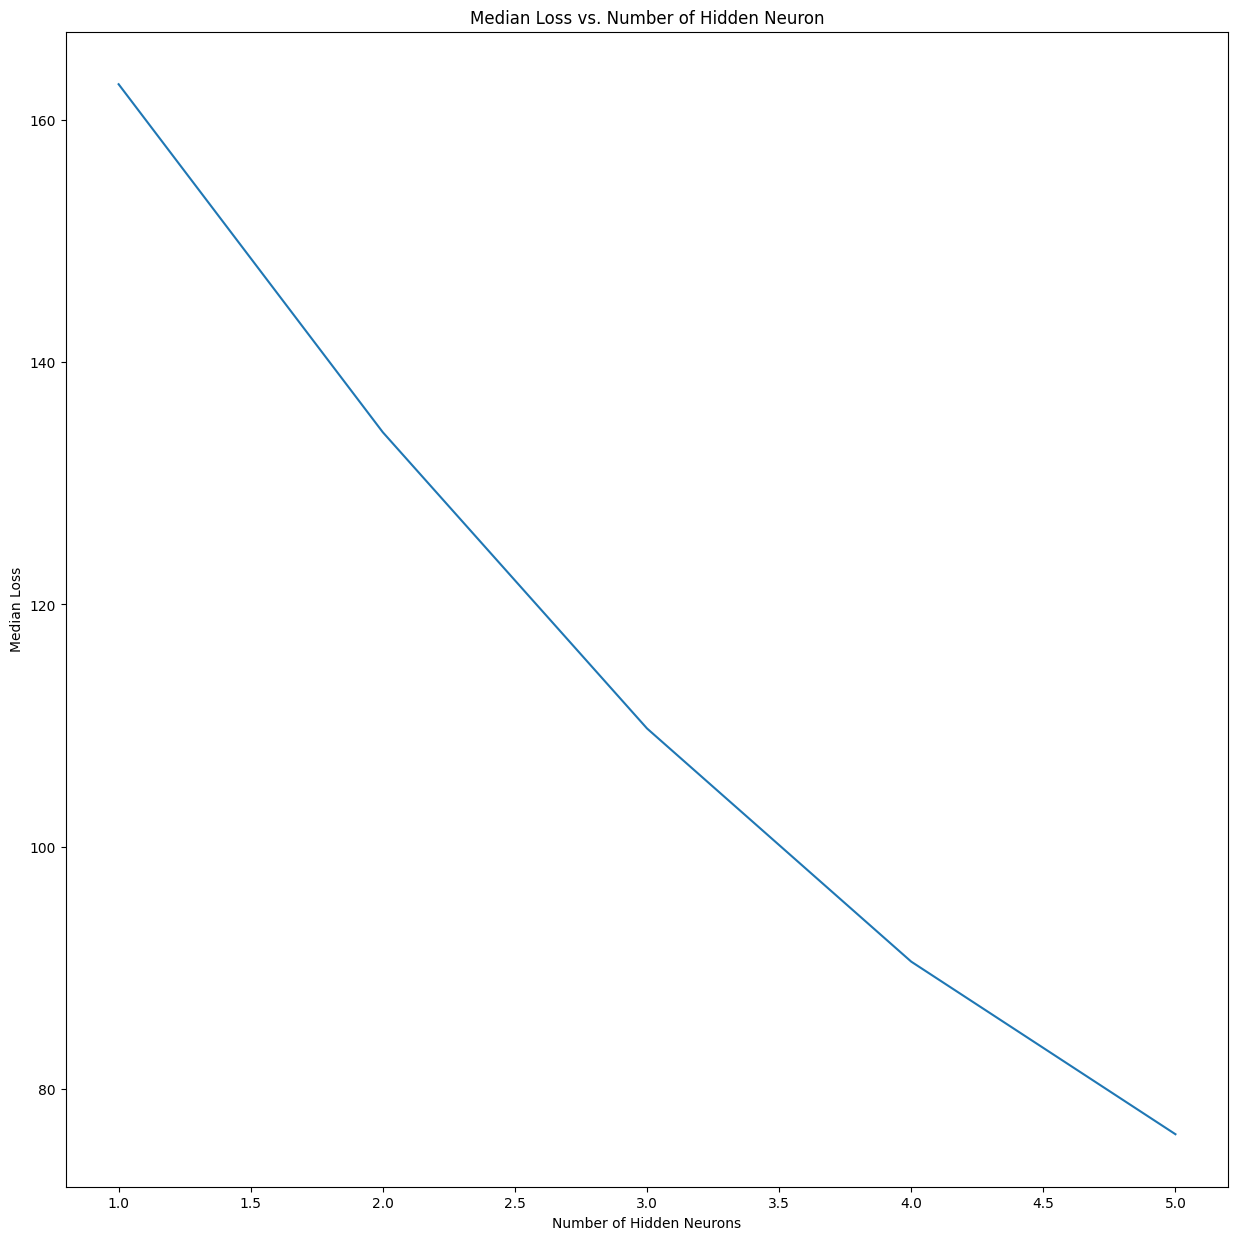

In [ ]:
median_losses = []

for hidden_neuron_idx in range(len(HIDDEN_LAYER_SIZES)):
    # Step 1) Get the last loss for all iterations corresponding to `hidden_neuron_idx` 
    last_losses: np.array = all_training_loss_histories[hidden_neuron_idx][:][-1]

    # Step 2) Take the median of the last lost (approximate how well the model performed)
    last_loss_median = np.median(last_losses)

    # Step 3) Append to array
    median_losses.append(last_loss_median)

    print(f"Median Losses: {median_losses[-1]}")

plt.plot(HIDDEN_LAYER_SIZES, median_losses)
plt.title("Median Loss vs. Number of Hidden Neuron")
plt.ylabel("Median Loss")
plt.xlabel("Number of Hidden Neurons")

### Step 5C) Visualize Classification
- See how each of the 1 hidden neuron vs the 5 hidden neurons model classify the vowels

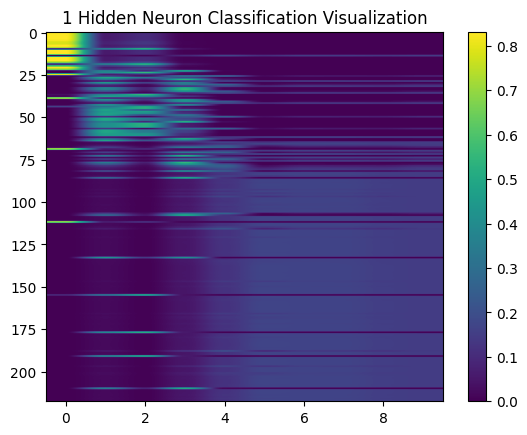

In [ ]:
model, optimizer = create_lpc_vowel_classifier(
    NUM_LPC=INPUT_SIZE,
    HIDDEN_LAYER_SIZE=1,
    ONE_HOT_ENCODING_SIZE=OUTPUT_SIZE,
    LEARNING_RATE=LEARNING_RATE
)

# Step 2) Train the model
loss_history = train_model(
    model=model,
    optimizer=optimizer,
    training_data=training_data,
    ground_truth=ground_truth,
    NUM_EPOCHS=NUM_EPOCHS,
    clock_rate=CLOCK_RATE,
    print_loss_flag=False
)

prediction = model(torch.tensor(training_data, dtype=torch.float))
plt.imshow(prediction.detach().numpy(), aspect='auto')
plt.title(f"1 Hidden Neuron Classification Visualization")
plt.colorbar()

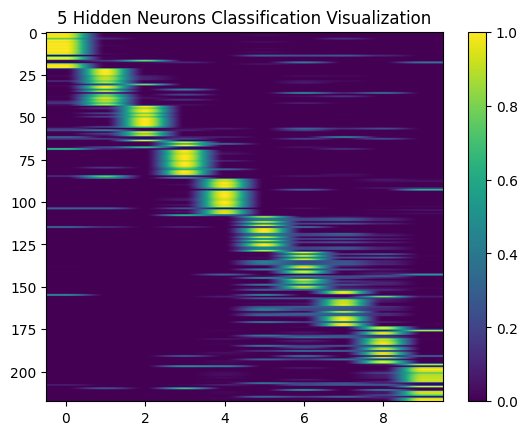

In [ ]:
model, optimizer = create_lpc_vowel_classifier(
    NUM_LPC=INPUT_SIZE,
    HIDDEN_LAYER_SIZE=5,
    ONE_HOT_ENCODING_SIZE=OUTPUT_SIZE,
    LEARNING_RATE=LEARNING_RATE
)

# Step 2) Train the model
loss_history = train_model(
    model=model,
    optimizer=optimizer,
    training_data=training_data,
    ground_truth=ground_truth,
    NUM_EPOCHS=NUM_EPOCHS,
    clock_rate=CLOCK_RATE,
    print_loss_flag=False
)

prediction = model(torch.tensor(training_data, dtype=torch.float))
plt.imshow(prediction.detach().numpy(), aspect='auto')
plt.title(f"5 Hidden Neurons Classification Visualization")
plt.colorbar()